# RBF


We choose a gaußian activation function for a RBF neuron with it's derivatives $$y(x)=e^{-\sum\limits_i\frac{(x_i-c_i)^2}{\sigma_i^2}}$$
$$\frac d{dc}y(x)=2\sigma^2(x-c)y(x)$$
$$\frac d{d\sigma}y(x)=-2(x-c)\sigma y(x)$$
$$\frac d{dx}y(x)=-2\sigma^2(x-c)y(x)$$

Where $x,c,\sigma\in \mathbb{R}^n$

# Experiments


The MNIST data set can be downloaded in *.CSV* [this](https://github.com/pjreddie/mnist-csv-png/blob/master/process_mnist.py) git repository.

## RBF

### Boolean Function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import layer
from neurons import RBF
from typing import List
import model

TRAIN_RATE:float = 0.0001
TRAIN:bool = True
FIRST_LAYER_NEURONS:int = 5
SECOND_LAYER_NEURONS:int = 10
NUM_LABELS:int = 2
TRAINING_REPITIONS:int = 100
BATCH_SIZE:int = 4


inputs = np.array([[0.0,0.0],[1.0,0.0],[0.0,1.0],[1.0,1.0]]).reshape(-1, BATCH_SIZE, 2)
expected = np.array([[1.0, 0.0], [1.0,0.0], [0.0,1.0], [0.0,1.0]]).reshape(-1, BATCH_SIZE, NUM_LABELS)

layers:List[layer.DenseLayer] = []
layers.append(layer.DenseLayer(2, FIRST_LAYER_NEURONS, RBF()))
#features = layers[-1].subsample_EM_init(inputs.reshape(-1,2)[:min(FIRST_LAYER_NEURONS, 4)], expected.reshape(-1,NUM_LABELS)[:min(FIRST_LAYER_NEURONS, 4)])
layers.append(layer.DenseLayer(FIRST_LAYER_NEURONS, SECOND_LAYER_NEURONS, RBF()))
#features = layers[-1].subsample_EM_init(features[:min(FIRST_LAYER_NEURONS, SECOND_LAYER_NEURONS)], expected.reshape(-1,NUM_LABELS)[:min(FIRST_LAYER_NEURONS, SECOND_LAYER_NEURONS)])
layers.append(layer.DenseLayer(SECOND_LAYER_NEURONS, NUM_LABELS, RBF()))
#features = layers[-1].subsample_EM_init(features[:min(NUM_LABELS, SECOND_LAYER_NEURONS)], expected.reshape(-1,NUM_LABELS)[:min(NUM_LABELS, SECOND_LAYER_NEURONS)])

m = model.Model(layers)

original_c = layers[0].neurons.c

if TRAIN:
    
    m.train(inputs, expected, TRAINING_REPITIONS)

    plt.plot(m.losses, label='Loss')
    plt.legend()

predicted_output = m.predict(inputs.reshape(1, 4, 2))

for i, output in enumerate(predicted_output.reshape(-1, NUM_LABELS)):
    out_string = ""
    for j in range(NUM_LABELS):
        out_string += f"{predicted_output[0,i,j]:.2f}, "

    print(f"Output: [{out_string}]\tExpected: {expected.reshape(-1, NUM_LABELS)[i]}")

pts = np.empty((FIRST_LAYER_NEURONS, 2))
colours = np.empty((FIRST_LAYER_NEURONS,3))
pts = layers[0].neurons.c
colours[:] = np.array([0.0,0.0,1.0])
plt.figure()
plt.scatter(original_c[:,0], original_c[:,1],c=colours)
colours[:] = np.array([1.0,0.0,0.0])
plt.scatter(pts[:,0], pts[:,1],c=colours)




In [ ]:
m.predict(inputs.reshape(1, 4, 2))

#### Results

* Even if the deviation can be trained, choosing a deviation that is too large, will result in odd behaviour.

  To give an example, if we're trying to learn the _AND_ function, the output will contain more zeros than ones. Using gradient decent it is better to decrease the error by creating many zeros which is done by moving away the center instead of lowering the deviation. In testing, this often results in getting in a state which is badly trained, but we cannot get out of.

* Training RBFs with multiple dense layers is less stable and will not converge as reliably using gradient decent. I believe this happens due to each RBF of lower levels 'prefering' a     different representation of the underlying feature space, and therefore no stable state is reached.

### MNIST

#### First test

##### Data Loading

In [1]:
'''Load data functions'''
import numpy as np
from pathlib import Path
from typing import Tuple
import pickle

def load_mnist_csv(path:Path) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Returns:
        labels, images
    '''
    raw_data:np.ndarray = np.loadtxt(path, delimiter=",")
    indices = np.arange(raw_data.shape[0])
    np.random.shuffle(indices)
    return raw_data[indices,0].astype(int), raw_data[indices,1:] / 255.0

def load_mnist_pickle(path:Path) -> Tuple[np.ndarray, np.ndarray]:
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data["labels"], data["data"]

def filter_mnist(data, labels, filter_id):
    indices = np.where(labels==filter_id)
    return data[indices], labels[indices]

def create_one_hot_encoding(labels:np.ndarray)->np.ndarray:
    '''
    Creates a one hot encoding of the labels.

    Assumes the labels start from 0.
    '''
    indices = np.empty((2, labels.shape[0]), dtype=int)
    indices[0,:] = np.arange(labels.shape[0])
    indices[1,:] = labels
    num_labels = np.max(labels + 1)
    encoded_labels = np.zeros((labels.shape[0], num_labels))
    encoded_labels[indices[0], indices[1]] = 1.0
    #encoded_labels = np.where(labels == 0, 1.0, 0.0).reshape(-1,1)
    return encoded_labels

def create_batches(data:np.ndarray, labels:np.ndarray, batch_size:int) -> Tuple[np.ndarray, np.ndarray]:
    return data.reshape(-1, batch_size, data.shape[1]), labels.reshape(-1, batch_size, labels.shape[1])


In [2]:
'''Load pickle data'''
BATCH_SIZE: int = 500

#Binary pickle files load much faster than the csv
train_labels, train_data = load_mnist_pickle(Path("mnist_train.pickle"))
train_labels = create_one_hot_encoding(train_labels)

validation_labels, validation_data = load_mnist_pickle(Path("mnist_test.pickle"))
validation_labels = create_one_hot_encoding(validation_labels)

train_data, train_labels = create_batches(train_data, train_labels, BATCH_SIZE)
validation_data, validation_labels = create_batches(validation_data, validation_labels, BATCH_SIZE)

In [2]:
'''Load csv data'''
BATCH_SIZE: int = 50

train_labels, train_data = load_mnist_csv(Path("mnist_train.csv"))
train_labels = create_one_hot_encoding(train_labels)

validation_labels, validation_data = load_mnist_csv(Path("mnist_test.csv"))
validation_labels = create_one_hot_encoding(validation_labels)

train_data, train_labels = create_batches(train_data, train_labels, BATCH_SIZE)
validation_data, validation_labels = create_batches(validation_data, validation_labels, BATCH_SIZE)

In [ ]:
'''Convert csv to pickle data'''
import pickle


train_labels, train_data = load_mnist_csv(Path("mnist_train.csv"))
with open("mnist_train.pickle", "wb") as f:
    pickle.dump({"data": train_data, "labels": train_labels}, f)

validation_labels, validation_data = load_mnist_csv(Path("mnist_test.csv"))
with open("mnist_test.pickle", "wb") as f:
    pickle.dump({"data": validation_data, "labels": validation_labels}, f)

##### Model creation and training

In [3]:
'''Create a model'''
from typing import List
import numpy as np
import layer
import model
from neurons import RBF
import loss

FIRST_LAYER_NEURONS:int = 1000
SECOND_LAYER_NEURONS:int = 1200
NUM_LABELS:int = train_labels.shape[2]

layers:List[layer.DenseLayer] = []
layers.append(layer.DenseLayer(train_data.shape[2], FIRST_LAYER_NEURONS, RBF()))
layers.append(layer.DenseLayer(FIRST_LAYER_NEURONS, SECOND_LAYER_NEURONS, RBF()))
layers.append(layer.DenseLayer(SECOND_LAYER_NEURONS, NUM_LABELS, RBF()))

m = model.Model(layers)

In [4]:
'''Create a model with smaller input regions'''
from typing import List
import numpy as np
import layer
import model
from neurons import RBF
import loss

FIRST_LAYER_NEURONS:int = 25
SECOND_LAYER_NEURONS:int = 20
NUM_LABELS:int = train_labels.shape[2]

train_data = train_data.reshape(-1, BATCH_SIZE, 28, 28)
validation_data = validation_data.reshape(-1, BATCH_SIZE, 28, 28)

layers:List[layer.DenseLayer] = []
layers.append(layer.ConvolutionalLayer(train_data.shape, 2, 5, RBF()))
lay: layer.ConvolutionalLayer = layers[-1]
layers.append(layer.ConvolutionalLayer((1, BATCH_SIZE, lay.num_horizontal, lay.num_vertical), 2, 5, RBF()))
lay: layer.ConvolutionalLayer = layers[-1]
#layers.append(layer.ConvolutionalLayer((1, BATCH_SIZE, lay.num_horizontal, lay.num_vertical), 2, 3, RBF()))
#lay: layer.ConvolutionalLayer = layers[-1]
#layers.append(layer.DenseLayer(lay.num_horizontal * lay.num_vertical, FIRST_LAYER_NEURONS, RBF()))
#layers.append(layer.DenseLayer(FIRST_LAYER_NEURONS, SECOND_LAYER_NEURONS, RBF()))
#layers.append(layer.DenseLayer(SECOND_LAYER_NEURONS, NUM_LABELS, RBF()))
layers.append(layer.DenseLayer(lay.num_horizontal * lay.num_vertical, NUM_LABELS, RBF()))

m = model.Model(layers)

In [5]:
'''Train the model.'''
from matplotlib import pyplot as plt

TRAINING_REPITIONS:int = 100
TRAIN_RATE:float = 0.001

m.train(train_input=train_data, train_output=train_labels, epochs=TRAINING_REPITIONS, train_rate=TRAIN_RATE, loss_function=loss.quadratic_error)

Training model for 100 epochs over 60000 training examples.


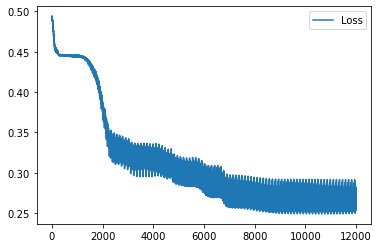

In [9]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(np.array(m.losses), label="Loss")
plt.legend()
plt.show()

In [ ]:
print(f"Average validation error: {m.validate(validation_data, validation_labels)}.")

In [10]:
def count_correct(input:np.ndarray, expected_labels:np.ndarray):
    output = m.predict(input).reshape(-1, 10)
    labels = np.argmax(output,axis=1)


    mask = labels == np.argmax(expected_labels.reshape(-1,10),axis=1)

    return np.sum(mask)
    #return np.sum(np.abs(np.where(m.predict(input).flatten() >= 0.5, 1.0, 0.0) - expected_labels.flatten()))

#print(f"Classified {count_correct(train_data, train_labels)} out of {train_data.shape[0] * train_data.shape[1]} training examples correctly.")
print(f"Classified {count_correct(validation_data, validation_labels)} out of {validation_data.shape[0] * validation_data.shape[1]} validation examples correctly.")

Predicting 10000 inputs.
Batch 20/20 | 100% |████████████████████████████████████████████████████████████████████████████████████████████████████|
Classified 6851 out of 10000 validation examples correctly.


In [ ]:
from matplotlib import pyplot as plt

def visualize_prototypes(rbf_weights:np.ndarray):
    grey_scale_image = np.empty((*rbf_weights.shape, 3))
    grey_scale_image[:,0] = rbf_weights
    grey_scale_image[:,1] = rbf_weights
    grey_scale_image[:,2] = rbf_weights
    plt.figure()
    plt.imshow(grey_scale_image.reshape(28, 28, 3))
    plt.show()

visualize_prototypes(m.layers[0].neurons.c[1])

In [ ]:
import serialize

serialize.serialize_model(m, "model.pickle")

Results show that these large dimensions heavly suffer from the vanishing gradient problem.

Two ideas I have for solving this are:
* BatchNorm layer
    * I believe this may be counter productive for learning as we generally want to increase the diversity and not normalize this.
    Although this may work in our favour since the network may be forced to create representations where the centers of a label are forced into different directions instead of just creating spacial distance.
* Implement RPROP, which suffers less from vanishing gradient as it only considers the behaviour relating towards the sign of a gradient vector.
* Make a "fractal" scheme where each neuron only learns a small dimensional subimage.